# **Assignment 4, Machine Learning 2020**

> Diego Useche Reyes, diusecher@unal.edu.co

> Sneyder Gantiva, esgantivar@unal.edu.co



## References 

Main Reference

[Arevalo, John, et al. "Gated multimodal units for information fusion." arXiv preprint arXiv:1702.01992 (2017).](https://arxiv.org/pdf/1702.01992.pdf)

Other References

[Vielzeuf, Valentin, et al. "Centralnet: a multilayer approach for multimodal fusion." Proceedings of the European Conference on Computer Vision (ECCV). 2018.](http://openaccess.thecvf.com/content_ECCVW_2018/papers/11134/Vielzeuf_CentralNet_a_Multilayer_Approach_for_Multimodal_Fusion_ECCVW_2018_paper.pdf)

[Multi-Label Image Classification with Neural Network | Keras](https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede)

[Recurrent Neural Networks by Example in Python](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)

[Machine Learning — Word Embedding & Sentiment Classification using Keras](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)

[Source code for training Gated Multimodal Units on MM-IMDb dataset](https://github.com/johnarevalo/gmu-mmimdb)

[Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

[Transfer Learning using Mobilenet and Keras](https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299)

[Tutorial on Keras flow_from_dataframe](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

[Keras MobileNet V2 transfer learning for the Stanford dogs dataset](https://www.kaggle.com/devang/transfer-learning-with-keras-and-mobilenet-v2)

[Multimodal Deep Learning to Predict Movie Genres](https://towardsdatascience.com/multimodal-deep-learning-to-predict-movie-genres-e6855f814a8a)

[Understanding Multilabel Classification Model and Accuracy Metrics](https://medium.com/towards-artificial-intelligence/understanding-multi-label-classification-model-and-accuracy-metrics-1b2a8e2648ca)

[Machine Learning Course Gonzalez 2020-1](https://fagonzalezo.github.io/ml-2020-1/)

[How to Concatenate Two Layers in Keras](https://intellipaat.com/community/3409/how-to-concatenate-two-layers-in-keras)

[Multimodal Information Fusion for Prohibited Items Detection](https://tech.mercari.com/entry/2019/09/12/130000)

## Setup GPU

In [132]:
# Setup the GPU
!nvidia-smi

Mon Jun 15 16:43:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   39C    P0    43W / 180W |  15734MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Libraries

In [57]:
# Usual Libraries
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.models import Model, load_model, model_from_json
from keras.layers import Dense as DenseKeras, GlobalAveragePooling2D, BatchNormalization, Dropout
from sklearn.metrics import f1_score
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [3]:
from fuel.datasets.hdf5 import H5PYDataset
import h5py

In [4]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_v2, decode_predictions as decode_predictions_v2
from keras.applications import imagenet_utils
from keras.initializers import glorot_normal

In [6]:
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

## Movie Poster Classification

Download the dataset MM-IMDB from http://lisi1.unal.edu.co/mmimdb/. The dataset
includes poster images from movies of different genres as well as the text of  the corresponding synopses.

As a preliminary work we need to preprocess dataset, for this task we propose the next class

In [13]:
class CreateDataset:
    _from = None
    _to = None
    
    _train_names = None
    _dev_names = None
    _validation_names = None
    
    
    _target_size = (96, 96)
    BASE_PATH = None
    
    def __init__(self, from_path='multimodal_imdb', to_path='assign4_mn2_96', BASE_PATH='/notebooks/storage/mmimdb'):
        self.from_path = f"/notebooks/storage/{from_path}.hdf5"
        self.to_path = f"/notebooks/storage/{to_path}.hdf5"
        self.BASE_PATH = BASE_PATH
        
    def open_from(self, mode='r'):
        self._from = h5py.File(self.from_path, mode=mode)
        
    def open_to(self, mode='r'):
        print(self.to_path)
        self._to = h5py.File(self.to_path, mode=mode)
    
    def close_to(self):
        self._to.flush()
        self._to.close()
        
    def get_path(self, path):
        return f'{self.BASE_PATH}/dataset/{path}'
    
    def preprocess(self):
        sets = [
            {
                'key': 'dev',
                'X': 'dev_images',
                'Y': 'dev_target'
            },
            {
                'key': 'test',
                'X': 'test_images',
                'Y': 'test_target'
            },            
            {
                'key': 'train',
                'X': 'train_images',
                'Y': 'train_target'
            }
        ]
        self.open_to(mode='w')
        try:
            for item in sets:
                names = H5PYDataset(self.from_path, which_sets=(item['key'],), sources = ['imdb_ids'], load_in_memory=True)
                X = np.empty((names.num_examples,self._target_size[0], self._target_size[1],3))
                print(f"init {item['key']}: {names.num_examples}")
                for i in range(names.num_examples):
                    name = names.data_sources[0][i].decode('utf-8')
                    X[i] = self._prepare_image(name)
                    if i % 1000 == 0:
                        print(i)
                print(X.shape)
                self._to.create_dataset(item['X'], data=X)
                self._to.flush()
                self._to.create_dataset(item['Y'], data=H5PYDataset(self.from_path, which_sets=(item['key'],), sources = ['genres'], load_in_memory=True).data_sources[0])
                self._to.flush()
                print(f"end {item['key']}")

            self._to.close()
        except ValueError:
            self._to.close()
            print('error')
    
    def _prepare_image(self, name):
        image_path = self.get_path(f"{name}.jpeg")
        img = load_img(image_path, target_size=self._target_size)
        img_array = img_to_array(img)
        return preprocess_input_v2(img_array)
        

In [14]:
create = CreateDataset()

Preprocess method take data from multimodal data set to build a new dataset 

In [15]:
create.preprocess()

/notebooks/storage/assign4_mn2_96.hdf5
init dev: 2608
0
1000
2000
(2608, 96, 96, 3)
end dev
init test: 7799
0
1000
2000
3000
4000
5000
6000
7000
(7799, 96, 96, 3)
end test
init train: 15552
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
(15552, 96, 96, 3)
end train


#### Utils
Utils functions

In [7]:
def save_model(model):
    model.save(f'/notebooks/storage/models/{model.name}.h5')
    print(f'saved as: {model.name}')

In [8]:
def load_model_utils(name):
    return load_model(f'/notebooks/storage/models/{name}.h5')

In [9]:
def load_checkpoint(name):
    return load_model(f'/notebooks/storage/checkpoints/{name}.hdf5')

In [10]:
def save_history(history, name):
    '''
        history: Generated from training process
        name: Name to persist the history on storage
    '''
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = f'/notebooks/storage/histories/{name}.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

In [11]:
def load_history(name):    
    '''
        name: Name to find and load history
    '''
    return pd.read_json(f'/notebooks/storage/histories/{name}.json')

In [12]:
def evaluate_model(X_p, y_p, model_p):
    # compute the prediction of the model
    y_pred = model_p.predict(X_p)
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0
    
    # compute the 4 types of f scores
    f_macro = f1_score(y_p, y_pred, average='macro')
    f_micro = f1_score(y_p, y_pred, average='micro')
    f_weighted = f1_score(y_p, y_pred, average='weighted')
    f_samples = f1_score(y_p, y_pred, average='samples')
    return (f_macro, f_micro, f_weighted, f_samples)

In [13]:
def plot_and_save_loss(history, title, name):
    '''
    history: dict,
    title: title of plot,
    name: name of file
    '''
    plt.plot(history['loss'], label='loss')
    plt.title(title)
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f"/notebooks/storage/histories/plots/{name}.pdf")

In [90]:
genres_names = np.array(['Drama','Comedy','Romance','Thriller','Crime','Action','Adventure','Horror','Documentary','Mystery',
                'Sci-Fi','Fantasy','Family','Biography','War','History','Music','Animation','Musical','Western', 
              'Sport','Short','Film-Noir'])

In [ ]:
tuple(genres_names[np.nonzero(y_pred_test[i])].tolist())

### Problem 1 (a)
Train a deep learning model to predict the genre. Use transfer learning with and without
fine tuning.

### Transfer Learning With MobileNetV2

#### Model (1)
For the transfer learning purpose we set False to all previous layers. Also add layers:
* GlobalAveragePooling2D
* Dense(100), activation=relu
* Dense(50), activation=relu

And layer to predict:

* Dense(23), activation sigmoid

The will be compile with loss function "binary_crossentropy" and "adam" optimizer, with 50 epochs

In [10]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = DenseKeras(100, activation='relu')(x)
x = DenseKeras(50, activation='relu')(x)
preds = DenseKeras(23, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds, name='model_mnv2_assign')
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[len(model.layers) - 4:]:
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_mnv2_assign"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

In [7]:
hf = h5py.File('/notebooks/storage/assign4_dataset.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

['dev_images',
 'dev_target',
 'test_images',
 'test_target',
 'train_images',
 'train_target']

In [11]:
history = model.fit(hf['train_images'], hf['train_target'], epochs=50, batch_size=100, validation_data=(hf['dev_images'], hf['dev_target']),shuffle="batch", callbacks=callbacks_list)

Train on 15552 samples, validate on 2608 samples
Epoch 1/50
15552/15552 [==============================] - 321s 21ms/step - loss: 0.3363 - accuracy: 0.8772 - val_loss: 0.3123 - val_accuracy: 0.8949

Epoch 00001: val_loss improved from inf to 0.31232, saving model to /notebooks/storage/checkpoints/weights-improvement-01-0.31.hdf5
Epoch 2/50
15552/15552 [==============================] - 179s 11ms/step - loss: 0.3013 - accuracy: 0.8940 - val_loss: 0.3252 - val_accuracy: 0.8953

Epoch 00002: val_loss did not improve from 0.31232
Epoch 3/50
15552/15552 [==============================] - 80s 5ms/step - loss: 0.3016 - accuracy: 0.8946 - val_loss: 0.3031 - val_accuracy: 0.8950

Epoch 00003: val_loss improved from 0.31232 to 0.30305, saving model to /notebooks/storage/checkpoints/weights-improvement-03-0.30.hdf5
Epoch 4/50
15552/15552 [==============================] - 96s 6ms/step - loss: 0.2979 - accuracy: 0.8954 - val_loss: 0.3031 - val_accuracy: 0.8949

Epoch 00004: val_loss did not improv

In [28]:
save_history(history, name='history_mn_fine_tuning')

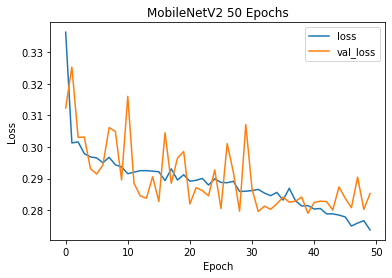

In [37]:
plot_and_save_loss(load_history('history_mn_fine_tuning'),title='MobileNetV2 50 Epochs', name='model_mnv2_assign_50_epochs_1')

In [14]:
model_e40 = load_model('/notebooks/storage/checkpoints/weights-improvement-40-0.28.hdf5')

In [16]:
evaluate_model(hf['test_images'], hf['test_target'], model_p=model_e40)

(0.04350832470383563,
 0.2967490753357991,
 0.18553550923326526,
 0.30406370780136643)

In [17]:
evaluate_model(hf['dev_images'], hf['dev_target'], model_p=model_e40)

(0.0442468621187562,
 0.30429759704251386,
 0.18967961455502697,
 0.31354836157366833)

In [18]:
evaluate_model(hf['train_images'], hf['train_target'], model_p=model_e40)

(0.046686772387933693,
 0.3110445904443494,
 0.1964283213576154,
 0.3200300467565128)

The following table reports the F-Scores by evaluate the proposed model (1) over training, validation and test datasets

|||**F-Score**|||
|:-- | :-: | :-: | :-: | :-: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.0467|0.3110|0.1964|0.3200|
|**Dev**|0.0442|0.3043|0.1897|0.3135|
|**Test**|0.0435|0.2967|0.1855|0.3040|

#### Model (2)
For the transfer learning purpose we set True to all layers. Also add layers:
* GlobalAveragePooling2D
* Dense(100), activation=relu
* Dense(50), activation=relu

And layer to predict:

* Dense(23), activation sigmoid

The will be compile with loss function "binary_crossentropy" and "adam" optimizer

In [ ]:
filepath="/notebooks/storage/checkpoints/weights-improvement-mn2-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [9]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = DenseKeras(100, activation='relu')(x)
x = DenseKeras(50, activation='relu')(x)
preds = DenseKeras(23, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds, name='model_mnv2_assign')
for layer in model.layers:
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_mnv2_assign"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

In [12]:
history = model.fit(hf['train_images'], hf['train_target'], epochs=50, batch_size=100, validation_data=(hf['dev_images'], hf['dev_target']),shuffle="batch", callbacks=callbacks_list)

Train on 15552 samples, validate on 2608 samples
Epoch 1/50
15552/15552 [==============================] - 568s 36ms/step - loss: 0.3422 - accuracy: 0.8686 - val_loss: 1.0037 - val_accuracy: 0.8949

Epoch 00001: val_loss improved from inf to 1.00372, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2-01-1.00.hdf5
Epoch 2/50
15552/15552 [==============================] - 410s 26ms/step - loss: 0.2942 - accuracy: 0.8958 - val_loss: 1.1029 - val_accuracy: 0.8964

Epoch 00002: val_loss did not improve from 1.00372
Epoch 3/50
15552/15552 [==============================] - 324s 21ms/step - loss: 0.2932 - accuracy: 0.8967 - val_loss: 0.4650 - val_accuracy: 0.8977

Epoch 00003: val_loss improved from 1.00372 to 0.46500, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2-03-0.46.hdf5
Epoch 4/50
15552/15552 [==============================] - 371s 24ms/step - loss: 0.2910 - accuracy: 0.8981 - val_loss: 0.3376 - val_accuracy: 0.8968

Epoch 00004: val_loss im

In [13]:
save_history(history, name='history_mn2_fine_tuning')

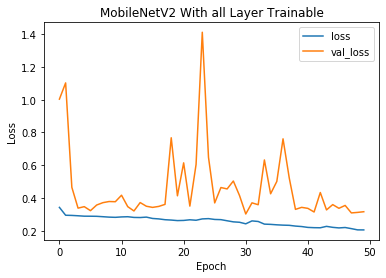

In [17]:
plot_and_save_loss(load_history('history_mn2_fine_tuning'), 'MobileNetV2 With all Layer Trainable', 'mobilenetv2_all_trainable')

In [30]:
model_all = load_checkpoint('weights-improvement-mn2-31-0.30')

We can see that the "val_loss" not have a good behavior, the strategy of allow trainable to all layers don't have a good results

In [34]:
evaluate_model(hf['train_images'], hf['train_target'], model_p=model_all)

(0.038234418023303816,
 0.22181392343724762,
 0.1433149138483251,
 0.21820008302454288)

In [32]:
evaluate_model(hf['dev_images'], hf['dev_target'], model_p=model_all)

(0.038635011056980514,
 0.22313056023082473,
 0.14663514810310568,
 0.22149369461486026)

In [33]:
evaluate_model(hf['test_images'], hf['test_target'], model_p=model_all)

(0.037936581492531506,
 0.2205268230003212,
 0.14277317012459217,
 0.2191184461988411)

The following table reports the F-Scores by evaluate the proposed model (2) over training, validation and test datasets


|||**F-Score**|||
|:-- | :-: | :-: | :-: | :-: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.0382|0.2218|0.1433|0.2182|
|**Dev**|0.0386|0.2231|0.1466|0.2215|
|**Test**|0.0379|0.2205|0.1428|0.2191|

#### Model (3)
For the transfer learning purpose we set False to all previous layers. Also add layers:
* GlobalAveragePooling2D
* Dense(100), activation=relu
* Dense(50), activation=relu

And layer to predict:

* Dense(23), activation sigmoid

The will be compile with loss function "binary_crossentropy" and "adam" optimizer

In [7]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = DenseKeras(100, activation='relu')(x)
x = DenseKeras(50, activation='relu')(x)
preds = DenseKeras(23, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds, name='model_mnv2_assign')
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[len(model.layers) - 4:]:
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_mnv2_assign"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

In [8]:
filepath="/notebooks/storage/checkpoints/weights-improvement-mn22-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [9]:
hf = h5py.File('/notebooks/storage/assign4_mn2.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

['dev_images',
 'dev_target',
 'test_images',
 'test_target',
 'train_images',
 'train_target']

In [10]:
history = model.fit(hf['train_images'], hf['train_target'], epochs=150, batch_size=100, validation_data=(hf['dev_images'], hf['dev_target']),shuffle="batch", callbacks=callbacks_list)

Train on 15552 samples, validate on 2608 samples
Epoch 1/150
15552/15552 [==============================] - 368s 24ms/step - loss: 0.3372 - accuracy: 0.8779 - val_loss: 0.3055 - val_accuracy: 0.8950

Epoch 00001: val_loss improved from inf to 0.30548, saving model to /notebooks/storage/checkpoints/weights-improvement-mn22-01-0.31.hdf5
Epoch 2/150
15552/15552 [==============================] - 176s 11ms/step - loss: 0.2995 - accuracy: 0.8937 - val_loss: 0.2990 - val_accuracy: 0.8961

Epoch 00002: val_loss improved from 0.30548 to 0.29898, saving model to /notebooks/storage/checkpoints/weights-improvement-mn22-02-0.30.hdf5
Epoch 3/150
15552/15552 [==============================] - 81s 5ms/step - loss: 0.3003 - accuracy: 0.8937 - val_loss: 0.3033 - val_accuracy: 0.8949

Epoch 00003: val_loss did not improve from 0.29898
Epoch 4/150
15552/15552 [==============================] - 92s 6ms/step - loss: 0.2963 - accuracy: 0.8948 - val_loss: 0.3081 - val_accuracy: 0.8949

Epoch 00004: val_loss 

In [11]:
save_history(history, name='history_mn22_fine_tuning')

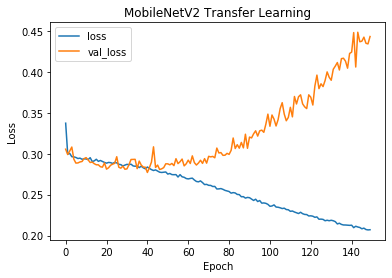

In [27]:
plot_and_save_loss(load_history('history_mn22_fine_tuning'), title='MobileNetV2 Transfer Learning', name='mn2_150epochs_tf')

In [28]:
model_e41 = load_checkpoint('weights-improvement-mn22-41-0.28')

In [18]:
evaluate_model(hf['train_images'], hf['train_target'], model_p=model_e41)

(0.08155387158538267,
 0.3421523994327935,
 0.23025554816260643,
 0.35124611970676783)

In [19]:
evaluate_model(hf['test_images'], hf['test_target'], model_p=model_e41)

(0.08068327640269268,
 0.3338796185935638,
 0.22372142544959484,
 0.3403345361737463)

In [20]:
evaluate_model(hf['dev_images'], hf['dev_target'], model_p=model_e41)

(0.07267405976899297,
 0.331029870708872,
 0.22037760093088601,
 0.33824222173531987)

The following table reports the F-Scores by evaluate the proposed model (3) over training, validation and test datasets


|||**F-Score**|||
|:-- | :-: | :-: | :-: | :-: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.0815|0.3421|0.2302|0.3512|
|**Dev**|0.0727|0.3310|0.2204|0.3382|
|**Test**|0.0807|0.3339|0.2237|0.3403|

#### Model (4)

We load MobileNetV2 from keras, not include the top layer and add some layers for able the model to learn new classes

MobileNetV2 need that the input be a squared array with size (224, 224, 3), the data has been preprocessed and is stored in a dataset HDF.

#### Create Model
For the transfer learning purpose we set False to all previous layers. Also add layers:
* GlobalAveragePooling2D
* Dropout(r=0.3)
* Dense(100), activation=relu
* Dropout(r=0.3)
* Dense(50), activation=relu

And layer to predict:

* Dense(23), activation sigmoid

The will be compile with loss function "binary_crossentropy" and "adam" optimizer

In [8]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = DenseKeras(100, activation='relu')(x)
x = Dropout(0.3)(x)
x = DenseKeras(50, activation='relu')(x)
preds = DenseKeras(23, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds, name='model_mnv2_2_assign')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_mnv2_2_assign"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________________________________________________________________

We present a summary of the Model where we can see that the trainable neurons are limited to the layers that we add to MobileNetV2 (Trainable params: 134323)

We create a "ModelCheckpoint" to save the model, this checkpoints will be created when the val_loss find a improvement

In [9]:
filepath="/notebooks/storage/checkpoints/weights-improvement-mn2_2-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Open the dataset of processed data

In [23]:
hf = h5py.File('/notebooks/storage/assign4_mn2.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

['dev_images',
 'dev_target',
 'test_images',
 'test_target',
 'train_images',
 'train_target']

Run process of training for created model

In [11]:
history = model.fit(hf['train_images'], hf['train_target'], epochs=50, batch_size=100, validation_data=(hf['dev_images'], hf['dev_target']),shuffle="batch", callbacks=callbacks_list)

Train on 15552 samples, validate on 2608 samples
Epoch 1/50
15552/15552 [==============================] - 352s 23ms/step - loss: 0.3592 - accuracy: 0.8713 - val_loss: 0.2994 - val_accuracy: 0.8960

Epoch 00001: val_loss improved from inf to 0.29939, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_2-01-0.30.hdf5
Epoch 2/50
15552/15552 [==============================] - 197s 13ms/step - loss: 0.3122 - accuracy: 0.8940 - val_loss: 0.2966 - val_accuracy: 0.8957

Epoch 00002: val_loss improved from 0.29939 to 0.29664, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_2-02-0.30.hdf5
Epoch 3/50
15552/15552 [==============================] - 84s 5ms/step - loss: 0.3083 - accuracy: 0.8939 - val_loss: 0.2947 - val_accuracy: 0.8950

Epoch 00003: val_loss improved from 0.29664 to 0.29471, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_2-03-0.29.hdf5
Epoch 4/50
15552/15552 [==============================] - 98s 6ms/step - loss: 0.

In [20]:
save_history(history,'history_mnv2_model_2_tf')

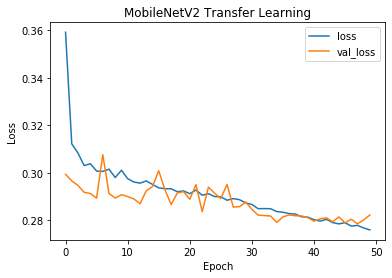

In [21]:
plot_and_save_loss(load_history('history_mnv2_model_2_tf'),name='mnv2_model_2_tf',title="MobileNetV2 Transfer Learning")

In [22]:
model_mbnt_tf = load_checkpoint('weights-improvement-mn2_2-48-0.28')

In [24]:
evaluate_model(hf['train_images'], hf['train_target'], model_p=model_mbnt_tf)

(0.06986026288334818,
 0.33587244688398493,
 0.2093728476978073,
 0.349411414631322)

In [25]:
evaluate_model(hf['dev_images'], hf['dev_target'], model_p=model_mbnt_tf)

(0.06590165624629078,
 0.327846975088968,
 0.20179641642297996,
 0.3413014899211218)

In [26]:
evaluate_model(hf['test_images'], hf['test_target'], model_p=model_mbnt_tf)

(0.070124539533083, 0.325759547804098, 0.20115392987793618, 0.3371454826320835)

The following table reports the F-Scores by evaluate the proposed model (4) over training, validation and test datasets

|||**F-Score**|||
| :-- | :---: | :---:| :---: | :---: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.0699|0.3359|0.2094|0.3494|
|**Dev**|0.0659|0.3278|0.2018|0.3413|
|**Test**|0.0701|0.3257|0.2011|0.3371|

#### Model (5)
For the transfer learning purpose we set False to all previous layers. Also add layers:
* GlobalAveragePooling2D
* Dense(100), activation=relu
* Dense(50), activation=relu

And layer to predict:

* Dense(23), activation sigmoid

The will be compile with loss function "binary_crossentropy" and "adam" optimizer with learning rate $lr=1e-3$

In [15]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = DenseKeras(100, activation='relu')(x)
x = DenseKeras(50, activation='relu')(x)
preds = DenseKeras(23, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds, name='model_mnv2_3_lr3')
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
model.summary()

Model: "model_mnv2_3_lr3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________

In [16]:
filepath="/notebooks/storage/checkpoints/weights-improvement-mn2_3_lr3-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [17]:
hf = h5py.File('/notebooks/storage/assign4_mn2.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

['dev_images',
 'dev_target',
 'test_images',
 'test_target',
 'train_images',
 'train_target']

In [18]:
history = model.fit(hf['train_images'], hf['train_target'], epochs=50, batch_size=100, validation_data=(hf['dev_images'], hf['dev_target']),shuffle="batch", callbacks=callbacks_list)

Train on 15552 samples, validate on 2608 samples
Epoch 1/50
15552/15552 [==============================] - 401s 26ms/step - loss: 0.3350 - accuracy: 0.8808 - val_loss: 0.3119 - val_accuracy: 0.8954

Epoch 00001: val_loss improved from inf to 0.31191, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_3_lr3-01-0.31.hdf5
Epoch 2/50
15552/15552 [==============================] - 177s 11ms/step - loss: 0.3026 - accuracy: 0.8955 - val_loss: 0.3303 - val_accuracy: 0.8927

Epoch 00002: val_loss did not improve from 0.31191
Epoch 3/50
15552/15552 [==============================] - 82s 5ms/step - loss: 0.2995 - accuracy: 0.8960 - val_loss: 0.3030 - val_accuracy: 0.8949

Epoch 00003: val_loss improved from 0.31191 to 0.30301, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_3_lr3-03-0.30.hdf5
Epoch 4/50
15552/15552 [==============================] - 96s 6ms/step - loss: 0.2985 - accuracy: 0.8957 - val_loss: 0.2995 - val_accuracy: 0.8957

Epoch 00004: val

In [19]:
save_history(history,'history_mnv2_3_lr3')

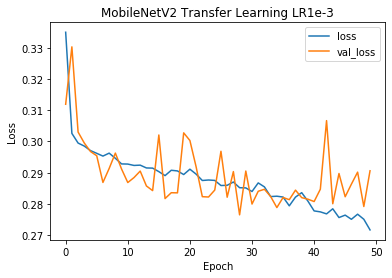

In [21]:
plot_and_save_loss(load_history('history_mnv2_3_lr3'), 'MobileNetV2 Transfer Learning LR1e-3', name='plott_mnv2_3_lr3')

In [20]:
model_5 = load_checkpoint('weights-improvement-mn2_3_lr3-29-0.28')

In [22]:
evaluate_model(hf['train_images'], hf['train_target'],model_p=model_5)

(0.05132608972059168,
 0.3113891876038713,
 0.20831956581108177,
 0.3110042545902885)

In [23]:
evaluate_model(hf['dev_images'], hf['dev_target'],model_p=model_5)

(0.04955607782608558,
 0.31032078103207816,
 0.20651227592020563,
 0.30809688139059305)

In [24]:
evaluate_model(hf['test_images'], hf['test_target'],model_p=model_5)

(0.049979864065382566,
 0.2982497265197687,
 0.19949384685855867,
 0.29723692699715265)

The following table reports the F-Scores by evaluate the proposed model (5) over training, validation and test datasets

|||**F-Score**|||
| :-- | :---: | :---:| :---: | :---: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.0513|0.3114|0.2083|0.3110|
|**Dev**|0.0495|0.3103|0.2065|0.3080|
|**Test**|0.0450|0.2982|0.1995|0.2972|

### Transfer Learning With fine Tuning

#### Model
We use Model (3) as base model to fine tuning, set all layer as trainable and modify the learning rate of Adam optimizer to $lr=1e-5$

In [25]:
model_fine_tuning = load_checkpoint('weights-improvement-mn22-41-0.28')
model.summary()

Model: "model_mnv2_3_lr3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________

In [27]:
for layer in model_fine_tuning.layers:
    layer.trainable = True

In [28]:
model_fine_tuning.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])
model_fine_tuning.summary()

Model: "model_mnv2_assign"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

In [29]:
filepath="/notebooks/storage/checkpoints/weights-improvement-mn2_fine_tuning-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [15]:
hf = h5py.File('/notebooks/storage/assign4_mn2.hdf5','r')
dataset_names = list(hf.keys())
dataset_names

['dev_images',
 'dev_target',
 'test_images',
 'test_target',
 'train_images',
 'train_target']

In [ ]:
history = model_fine_tuning.fit(hf['train_images'], hf['train_target'], epochs=50, batch_size=100, validation_data=(hf['dev_images'], hf['dev_target']),shuffle="batch", callbacks=callbacks_list)

Train on 15552 samples, validate on 2608 samples
Epoch 1/50
15552/15552 [==============================] - 372s 24ms/step - loss: 0.2791 - accuracy: 0.9004 - val_loss: 0.2821 - val_accuracy: 0.8986

Epoch 00001: val_loss improved from inf to 0.28214, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_fine_tuning-01-0.28.hdf5
Epoch 2/50
15552/15552 [==============================] - 394s 25ms/step - loss: 0.2733 - accuracy: 0.9016 - val_loss: 0.2803 - val_accuracy: 0.8995

Epoch 00002: val_loss improved from 0.28214 to 0.28026, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_fine_tuning-02-0.28.hdf5
Epoch 3/50
15552/15552 [==============================] - 349s 22ms/step - loss: 0.2698 - accuracy: 0.9026 - val_loss: 0.2789 - val_accuracy: 0.8997

Epoch 00003: val_loss improved from 0.28026 to 0.27892, saving model to /notebooks/storage/checkpoints/weights-improvement-mn2_fine_tuning-03-0.28.hdf5
Epoch 4/50
15552/15552 [=========================

In [ ]:
save_history(history,'history_mnv2_fine_tuning')

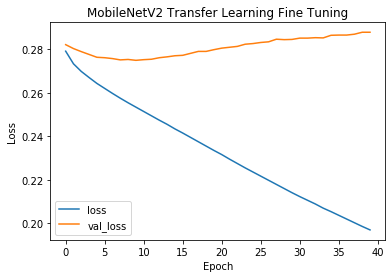

In [23]:
plot_and_save_loss(load_history('history_mnv2_fine_tuning'), 'MobileNetV2 Transfer Learning Fine Tuning', name='plot_mnv2_fine_tuning')

In [14]:
model_fn = load_checkpoint('weights-improvement-mn2_fine_tuning-10-0.27')

In [19]:
evaluate_model(hf['test_images'], hf['test_target'],model_p=model_fn)

(0.08469906669821028,
 0.33855076774361453,
 0.23632907733477843,
 0.3453703873308951)

In [20]:
evaluate_model(hf['dev_images'], hf['dev_target'],model_p=model_fn)

(0.0804795432358683,
 0.33752643882889904,
 0.23580016598914066,
 0.3437926039536469)

In [21]:
evaluate_model(hf['train_images'], hf['train_target'],model_p=model_fn)

(0.11446770208189076,
 0.388620861753452,
 0.2798782327462654,
 0.3926270806382689)

The following table reports the F-Scores by evaluate the proposed model with fine tuning over training, validation and test datasets

|||**F-Score**|||
| :-- | :---: | :---:| :---: | :---: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.1145|0.3886|0.2799|0.3926|
|**Dev**|0.0805|0.3375|0.2358|0.3438|
|**Test**|0.0847|0.3385|0.2363|0.3453|

### Results

The following table show the summary of F-Score for proposed models. The best model with the best scores is **Transfer Learning with Fine Tuning** this model was based on trained proposed Model (3) 

|||**F-Score: Test dataset** |||
| :-- | :---: | :---:| :---: | :---: |
|**Model**|macro|micro|weighted|samples|
|**Model (1)**|0.0435|0.2967|0.1855|0.3040|
|**Model (2)**|0.0379|0.2205|0.1428|0.2191|
|**Model (3)**|0.0807|0.3339|0.2237|0.3403|
|**Model (4)**|0.0701|0.3257|0.2011|0.3371|
|**Model (5)**|0.0450|0.2982|0.1995|0.2972|
|**Fine Tuning**|0.085|0.339 |0.236 |0.345|


The following table show the results of the reported models on (Arevalo, 2017), and the results of the proposed model with fine tuning. We can observe that this visual model performed slightly worst that the models in 

|||**F-Score Test dataset** |||
| :-- | :---: | :---:| :---: | :---: |
|**Model**|macro|micro|weighted|samples|
|**Proposed model with Fine Tuning**|0.085|0.339 |0.236 |0.345|
|**VGG Transfer**| 0.284 | 0.437 | 0.410 | 0.429 |
|**CNN end2end**| 0.210 | 0.340 | 0.370 | 0.350 |

## Problem 2(a)

**Movie synopsis classification**

a) Train a recurrent neural network over the movie synopsis texts to predict the movie genre.

## Libraries for NL Model

In [119]:
# Usual Libraries
import numpy as np
import h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input
from keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.applications import MobileNetV2
from fuel.datasets.hdf5 import H5PYDataset

### Overall Approach 

The overall approach for this part of the assignment was to use as embedding the word2vec representation trained in https://github.com/johnarevalo/gmu-mmimdb. We extracted the word2vec vectors from the file metadata.npy, and the sequences of the plots from the multimodal_imdb.hdf5 file.

The vectors of the word2vec have 300 dimensions and the sequences were padded and truncated to 300 elements.

We trained our own LSTM Model with 60 Units, we used 3 densed layers (100,50,23), and dropouts between the layers, we used 23 neurons in the output layer 1 neuron for each genre, with sigmoid as the activation, and binary_cross_entropy as the loss function in order to do the multilabel classification, in total we put 150 epochs because the model did not converged easily. To evaluate the model we used the 4 types of F-Scores.

### Data Preprocessing

Extract the the 'sequences' and 'genres' of word vectors of the plots of the Train, Validation('development') and Test data sets from the .h5py file

In [120]:
# # Extract the sequences and genres of Train Google Drive
# train_sequences = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('train',), sources = ['sequences'], load_in_memory=True)
# train_genres = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('train',), sources = ['genres'], load_in_memory=True)
# # Extract the sequences and genres of Validation ('dev') 
# validation_sequences = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['sequences'], load_in_memory=True)
# validation_genres = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['genres'], load_in_memory=True)
# # Extract the sequences and genres of Test
# test_sequences = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('test',), sources = ['sequences'], load_in_memory=True)
# test_genres = H5PYDataset('/content/drive/My Drive/Machine Learning 2020/multimodal_imdb.hdf5', which_sets=('test',), sources = ['genres'], load_in_memory=True)

# Extract the sequences and genres of Train PaperSpace
train_sequences = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('train',), sources = ['sequences'], load_in_memory=True)
train_genres = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('train',), sources = ['genres'], load_in_memory=True)
# Extract the sequences and genres of Validation ('dev') 
validation_sequences = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['sequences'], load_in_memory=True)
validation_genres = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('dev',), sources = ['genres'], load_in_memory=True)
# Extract the sequences and genres of Test
test_sequences = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('test',), sources = ['sequences'], load_in_memory=True)
test_genres = H5PYDataset('storage/multimodal_imdb.hdf5', which_sets=('test',), sources = ['genres'], load_in_memory=True)

Request the data out of the fuel

In [121]:
# Save the data in six variables
X_train, = train_sequences.data_sources
X_validation, = validation_sequences.data_sources
X_test, = test_sequences.data_sources
y_train, = train_genres.data_sources
y_validation, = validation_genres.data_sources
y_test, = test_genres.data_sources

X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((15552,), (2608,), (7799,), (15552, 23), (2608, 23), (7799, 23))

To show the nature of the training data set, we print one value of Train data set

They are sequences of words, as expected.

In [122]:
print(X_train[1000])

[ 4550     1     2  5456   367     7 60874    28   853 29402   216    33
    12   376    37   242   192  1188    54     4 10290  3638   373    17
   364  4550     4 33726   124     2   168  2543  4912     3     2  1961
     1    19     9     8 10038    15  4550  8323     2   112  1743     1
  1600 38813     1    21     2    51   853  6901    17    12    11   937
    38   924     6   443     3    27    62     2  1961   193    11    64
   235     9    17 38813    55     4  2951   231   537  7423     1   336
 38426     1     5     9   318     6   553   407     2  1630  8167   336
 38426  2158     6    38    10  2951     3  2298     4   383 14652  1726
    31 13324 14585    21   827   655 41169     1    56   293   173    48
    86     2  3674    18  5883 16288    11    13    29 14623 20785    29
   991     1  6468  1856 48433     3]


Extract the word2Vec pretrained model in https://github.com/johnarevalo/gmu-mmimdb from the metadata.npy file, save the vectors in word_vecs variable

In [123]:
# Extract the word2vec model Drive
# metadata = np.load('/content/drive/My Drive/Machine Learning 2020/metadata.npy', allow_pickle=True)

# Extract the word2vec model PaperSpace
metadata = np.load('storage/metadata.npy', allow_pickle=True)

# Save the model in the followed variables
metadata_dict = metadata[()]
word_vecs= metadata_dict.get('lookup')
vocab_size = metadata_dict.get('vocab_size')
idx_word = metadata_dict.get('ix_to_word')
word_to_idx = metadata_dict.get('word_to_ix')

Given a sequence of the X and the function ix_to_word we can retrieve the 'plot' of the sample, as shown in the example.

In [124]:
print(' '.join(idx_word[w] for w in X_train[1000]))

kent , the unscrupulous boss of bottleneck has sheriff keogh killed when he asks one too many questions about a rigged poker game that gives kent a stranglehold over the local cattle rangers . the mayor , who is in cahoots with kent appoints the town drunk , washington dimsdale , as the new sheriff assuming that he ' ll be easy to control . but what the mayor doesn ' t know is that dimsdale was a deputy under famous lawman , tom destry , and is able to call upon the equally formidable tom destry jr to be his deputy . featuring a career reviving performance from marlene dietrich as bar singer frenchie , which could well have been the inspiration for madeline kahn ' s " blazing saddles " character , lili von schtupp .


Padding with zeros the X_train and X_validation because not all sequences have the same number of words and the RNN requires that all the sequences to have the same number of words. And printing the average size of the sequences and the maximum sequence

In [125]:
# Function which returns the average and maximum number of words in the sequences to find the optimal padding
def optimal_padding(X_p):
  num_train = X_p.shape[0]
  max_len_seq = 0
  ave_len_seq = 0

  for i in range(num_train):   
    seq_len_i = X_p[i].shape[0]
    ave_len_seq += seq_len_i
    if seq_len_i > max_len_seq:
      max_len_seq = seq_len_i
    
  ave_len_seq /= num_train
  return  max_len_seq, ave_len_seq

optimal_padding(X_train)

(1863, 125.0821116255144)

Perform the padding with zeroes and truncating choosing 500 as the number of words for all sequences as an optimal value.

Hence, we would have all sequences of 500 elements.

In [126]:
'''
Taken from: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
'''
# truncate and pad input sequences with zeos
max_review_length = 300
X_train2 = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_validation2 = sequence.pad_sequences(X_validation, maxlen=max_review_length)
X_test2 = sequence.pad_sequences(X_test, maxlen=max_review_length)

X_train2.shape, X_validation2.shape, X_test2.shape

((15552, 300), (2608, 300), (7799, 300))

Perform a padding of the vectors of words because some words in the sequences do not have a correspondent word2vec, hence we a assign a word2vec of all zeros for such rare words.

The padding is done so that the axis = 0 of the matrix is equal to the vobulary size.

In [127]:
# Padding the word vectors to for the embedding_matrix so there are same number of word vecs as number of elements of vocabulary
embedding_matrix = np.pad(word_vecs, ((0, vocab_size - word_vecs.shape[0]),(0,0)))
embedding_matrix.shape, vocab_size

((69980, 300), 69980)

In [128]:
# Create embbedding constant for the embedding
EMBEDDING_DIM = embedding_matrix.shape[1]
EMBEDDING_DIM

300

Then, we have formed the embedding matrix, and the sequences to feed the RNN.

### Model: Shallow LSTM

In [133]:
'''
Inspired from: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
and https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede
and https://intellipaat.com/community/3409/how-to-concatenate-two-layers-in-keras
'''
#Create the model 1 LSTM Model
inputs = Input(shape=(max_review_length,))
embedding_layer1 = Embedding(vocab_size,
                            EMBEDDING_DIM,  
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_review_length,
                            trainable = False)(inputs)
model1 = Dropout(0.3)(embedding_layer1)
model1 = LSTM(units=60)(model1)
model1 = Dropout(0.3)(model1)
model1 = Dense(100, activation='relu')(model1)
model1 = Dropout(0.3)(model1)
model1 = Dense(50, activation='relu')(model1)
model1 = Dropout(0.3)(model1)
model1 = Dense(23, activation='sigmoid')(model1)
nlp_model = Model(inputs=[inputs], outputs=[model1])
nlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(nlp_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 300)          20994000  
_________________________________________________________________
dropout_11 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                86640     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               6100      
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0   

In [134]:
history = nlp_model.fit(X_train2, y_train, epochs=150, batch_size=64, validation_data=(X_validation2, y_validation))

Train on 15552 samples, validate on 2608 samples
Epoch 1/150
15552/15552 [==============================] - 40s 3ms/sample - loss: 0.3486 - accuracy: 0.8685 - val_loss: 0.2888 - val_accuracy: 0.8949
Epoch 2/150
15552/15552 [==============================] - 35s 2ms/sample - loss: 0.2992 - accuracy: 0.8938 - val_loss: 0.2879 - val_accuracy: 0.8949
Epoch 3/150
15552/15552 [==============================] - 35s 2ms/sample - loss: 0.2946 - accuracy: 0.8949 - val_loss: 0.2875 - val_accuracy: 0.8950
Epoch 4/150
15552/15552 [==============================] - 35s 2ms/sample - loss: 0.2911 - accuracy: 0.8961 - val_loss: 0.2848 - val_accuracy: 0.8965
Epoch 5/150
15552/15552 [==============================] - 35s 2ms/sample - loss: 0.2885 - accuracy: 0.8968 - val_loss: 0.2843 - val_accuracy: 0.8964
Epoch 6/150
15552/15552 [==============================] - 35s 2ms/sample - loss: 0.2864 - accuracy: 0.8970 - val_loss: 0.2808 - val_accuracy: 0.8972
Epoch 7/150
15552/15552 [==========================

Plot the train and validation loss, code taken from the Handout-CNN-sentence-sentence-classification.ipynb from ML class Fabio Gonzalez
https://fagonzalezo.github.io/ml-2020-1/

In [135]:
save_history(history, 'history_shallow_LSTM')

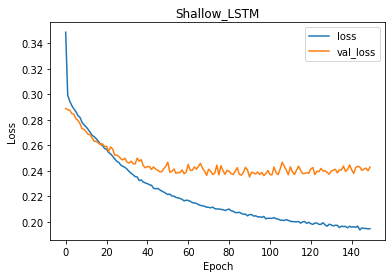

In [136]:
plot_and_save_loss(load_history('history_shallow_LSTM'), 'Shallow_LSTM', 'plot_shallow_LSTM')

Save Model

In [137]:
save_large_model(model=nlp_model, name='shallow_LSTM_model')

## Problem 2(b)

b) Evaluate and analyze the results. Compare your results with the ones reported in the paper. Discuss the results.

Create a function which returns the 4 types 4 f-scores reported in the paper.

In [138]:
# evaluates the model over a data set returning the 4 types of f-scores
def evaluate_model(X_p, y_p, model_p = nlp_model):
  # compute the prediction of the model
  y_pred = model_p.predict(X_p)
  y_pred[y_pred>=0.5] = 1
  y_pred[y_pred<0.5] = 0

  # compute the 4 types of f scores
  f_macro = f1_score(y_p, y_pred, average='macro').round(3)
  f_micro = f1_score(y_p, y_pred, average='micro').round(3)
  f_weighted = f1_score(y_p, y_pred, average='weighted').round(3)
  f_samples = f1_score(y_p, y_pred, average='samples').round(3)

  return (f_macro, f_micro, f_weighted, f_samples)

Compute the f-scores, of train, validation, and test data set

In [140]:
evaluate_model(X_train2, y_train)

(0.412, 0.643, 0.601, 0.644)

In [141]:
evaluate_model(X_validation2, y_validation)

(0.261, 0.474, 0.43, 0.466)

In [143]:
evaluate_model(X_test2, y_test)

(0.266, 0.478, 0.434, 0.471)

### Results

The results on train, dev and test data sets of the **Shallow LSTM** model are shown in the following picture.

|||**F-Score: Shallow LSTM**|||
| :-- | :---: | :---:| :---: | :---: |
|**dataset**|macro|micro|weighted|samples|
|**Train**|0.412|0.643|0.601|0.644|
|**Dev**|0.261|0.474| 0.430|0.466|
|**Test**|0.266| 0.478|0.434|0.471|

The results compared on **Test** data set on our **Shallow LSTM** model with respect to the best and the worst models on text reported on the paper are, 

|||**F-Score: Test dataset** |||
| :-- | :---: | :---:| :---: | :---: |
|**Model**|macro|micro|weighted|samples|
|**Shallow LSTM**|0.266| 0.478|0.434|0.471|
|**RNN end2end**| 0.370| 0.490| 0.490|0.490|
|**MaxoutMLP w2v**|0.488|0.595| 0.588| 0.592|

In conclusion, our 'Shallow LSTM' model performs decently but worst than the models reported on the paper, that is probably because we did not have the time to explore more architectures and embeddings. 

## Problem 3(a)

Create a model than combines the models from the question 1 and 2 for multimodal
movie classification. Clearly explain your approach. Include a diagram of your model. Train the model.

In [104]:
# Usual Libraries
import numpy as np
import h5py
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input, GlobalAveragePooling2D, Reshape, MaxPooling2D, AveragePooling2D, Flatten, Input
from keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.applications import MobileNetV2
from fuel.datasets.hdf5 import H5PYDataset
from tensorflow.keras.preprocessing.image import array_to_img

In [3]:
mobile_net_v2 = MobileNetV2(include_top=False, weights = 'imagenet', input_shape=(96,96,3))
mobile_net_v2.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [4]:
mobile_net_v2.inputs

[<tf.Tensor 'input_1:0' shape=(None, 96, 96, 3) dtype=float32>]

### Multimodal Model: Proposed MaxAvePool Method

The model is based on MobileNetV2 with input shape of (96, 96, 3) for images, and LSTM with embedding for text

The fusion model consist on taking two dense layers with 100 neurons of the visual and textual models, and doing a MaxPooling and an AveragePooling between the neurons in the ith position, that leads to two layers of 100 units, and then doing an AveragePooling , between the previous Max and Ave pools, leading to only one layer of 100 units. This model is depicted in the picture, the concatenation were done to perfom the operations previously presented. Dropout layers are placed in order to avoid overfitting.

![Multimodal](https://ml-esgantivar.s3.amazonaws.com/Multimodal.png "Model Diagram")

Create a model to movie synopsis classification

In [19]:
'''
Inspired from: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
and https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede
and https://intellipaat.com/community/3409/how-to-concatenate-two-layers-in-keras
and https://tech.mercari.com/entry/2019/09/12/130000
'''

#Create the model 1 LSTM Model
inputs_1 = Input(shape=(max_review_length,))
embedding_layer1 = Embedding(vocab_size,
                            EMBEDDING_DIM,  
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_review_length,
                            trainable = False)(inputs_1)
model_text = Dropout(0.3)(embedding_layer1)
model_text = LSTM(units=60)(model_text)
model_text = Dropout(0.3)(model_text)
model_text = Dense(100)(model_text)

Create a model to movie poster classification

In [20]:
#Create the model 2 Visual Model based on MobileNetV2
inputs_2 = Input(shape=(96,96,3,))
base_model = MobileNetV2(include_top=False, weights = 'imagenet', input_shape=(96,96,3))
for layer in base_model.layers:
    layer.trainable = False
model_visual = base_model.output
model_visual = GlobalAveragePooling2D()(model_visual)
model_visual = Dropout(0.3)(model_visual)
model_visual = Dense(100, activation='relu')(model_visual)
model_visual = Dropout(0.3)(model_visual)
model_visual = Dense(50, activation='relu')(model_visual)
model_visual = Dropout(0.3)(model_visual)
model_visual = Dense(100, activation='relu')(model_visual)
model_visual

<tf.Tensor 'dense_3/Identity:0' shape=(None, 100) dtype=float32>

Merge the models with a proposed pool

In [21]:
reshaped_model1 = Reshape((100, 1, 1))(model_text)
reshaped_model2 = Reshape((100, 1, 1))(model_visual)
concatenated = Concatenate(axis=2)([reshaped_model1, reshaped_model2])
max_pool = MaxPooling2D(pool_size=(1, 2), strides=None, padding='valid', data_format=None)(concatenated)
ave_pool = AveragePooling2D(pool_size=(1, 2), strides=None, padding='valid', data_format=None)(concatenated)
concatenated_pools = Concatenate(axis=2)([max_pool, ave_pool])
proposed_pool = AveragePooling2D(pool_size=(1, 2), strides=None, padding='valid', data_format=None)(concatenated_pools)
proposed_pool = Flatten()(proposed_pool)
model_merged = Dropout(0.3)(proposed_pool)
model_merged = Dense(50, activation='relu')(model_merged)
model_merged = Dropout(0.3)(model_merged)
model_merged = Dense(23, activation='sigmoid')(model_merged)
pool_model = Model(inputs=[inputs_1, base_model.inputs], outputs=[model_merged], name='pool_model')
pool_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(pool_model.summary())

Model: "pool_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
_________________________________________________________________________________________

In [22]:
hf_visual = h5py.File('/notebooks/storage/assign4_mn2_96.hdf5','r')
dataset_names = list(hf_visual.keys())
dataset_names

['dev_images',
 'dev_target',
 'test_images',
 'test_target',
 'train_images',
 'train_target']

In [23]:
hf_text = h5py.File('/notebooks/storage/assign4_text.hdf5','r')

In [24]:
hf_text['test_text'].shape

(7799, 300)

In [25]:
train_text = hf_text['train_text'][()]

In [26]:
train_images = hf_visual['train_images'][()]

In [27]:
dev_text =  hf_text['dev_text'][()]

In [28]:
dev_images = hf_visual['dev_images'][()]

In [29]:
y_val = hf_visual['dev_target'][()]

In [30]:
y = hf_visual['train_target'][()]

In [37]:
filepath="/notebooks/storage/checkpoints/weights-improvement-mmodal-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [31]:
history = pool_model.fit(x=[train_text, train_images], y=y, epochs=150, batch_size=100, validation_data=([dev_text, dev_images], y_val))

Train on 15552 samples, validate on 2608 samples
Epoch 1/150
15552/15552 [==============================] - 39s 2ms/sample - loss: 0.3575 - accuracy: 0.8630 - val_loss: 0.2881 - val_accuracy: 0.8949
Epoch 2/150
15552/15552 [==============================] - 23s 1ms/sample - loss: 0.3026 - accuracy: 0.8943 - val_loss: 0.2843 - val_accuracy: 0.8949
Epoch 3/150
15552/15552 [==============================] - 23s 1ms/sample - loss: 0.2938 - accuracy: 0.8954 - val_loss: 0.2788 - val_accuracy: 0.8960
Epoch 4/150
15552/15552 [==============================] - 23s 1ms/sample - loss: 0.2888 - accuracy: 0.8974 - val_loss: 0.2758 - val_accuracy: 0.8993
Epoch 5/150
15552/15552 [==============================] - 23s 1ms/sample - loss: 0.2840 - accuracy: 0.8984 - val_loss: 0.2706 - val_accuracy: 0.8997
Epoch 6/150
15552/15552 [==============================] - 23s 2ms/sample - loss: 0.2803 - accuracy: 0.8996 - val_loss: 0.2686 - val_accuracy: 0.9008
Epoch 7/150
15552/15552 [==========================

In [32]:
save_history(history, 'history_mmodal_2')

Plot the train and validation loss, code taken from the Handout-CNN-sentence-sentence-classification.ipynb from ML class Fabio Gonzalez
https://fagonzalezo.github.io/ml-2020-1/

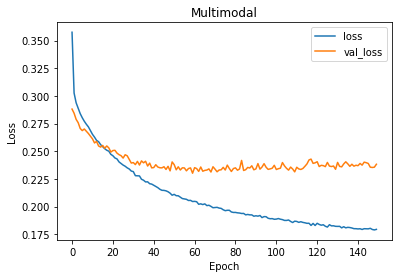

In [33]:
plot_and_save_loss(load_history('history_mmodal_2'), 'Multimodal', 'plot_mmodal_2')

In [34]:
del train_text
del train_images
del dev_text
del dev_images
del y_val
del y

### Evaluate M2: Proposed MaxAvePool Method

Compute the f-scores, of train, validation, and test data set

In [35]:
dev_text = hf_text['dev_text'][()]
dev_text.shape

(2608, 300)

In [36]:
dev_images = hf_visual['dev_images'][()]
dev_images.shape

(2608, 96, 96, 3)

In [37]:
dev_target = hf_visual['dev_target'][()]
dev_target.shape

(2608, 23)

In [40]:
evaluate_model_multimodal(dev_text, dev_images, dev_target, pool_model)

(0.26483576563152644,
 0.5015387484845659,
 0.44917655971924575,
 0.4997895254030223)

In [41]:
del dev_text
del dev_images
del dev_target

In [42]:
test_text = hf_text['test_text'][()]
test_text.shape

(7799, 300)

In [43]:
test_images = hf_visual['test_images'][()]
test_images.shape

(7799, 96, 96, 3)

In [44]:
test_target = hf_visual['test_target'][()]
test_target.shape

(7799, 23)

In [45]:
evaluate_model_multimodal(test_text, test_images, test_target, pool_model)

(0.26311256785029735,
 0.49311208515967436,
 0.4425338679407566,
 0.490060608280893)

In [46]:
del test_text
del test_images
del test_target

In [47]:
train_text = hf_text['train_text'][()]
train_text.shape

(15552, 300)

In [48]:
train_images = hf_visual['train_images'][()]
train_images.shape

(15552, 96, 96, 3)

In [49]:
train_target = hf_visual['train_target'][()]
train_target.shape

(15552, 23)

In [50]:
evaluate_model_multimodal(train_text, train_images, train_target, pool_model)

(0.3802987457703888,
 0.6393397608005859,
 0.5855170795495354,
 0.6453503051303977)

In [51]:
del train_text
del train_images
del train_target

### Results

The following table reports F-Scores by evaluate the proposed **MaxAve Pool** multimodal model over training, validation and test datasets

|||**F-Score: MaxAve Pool**|||
| :-- | :---: | :---:| :---: | :---: |
|**Dataset**|macro|micro|weighted|samples|
|**Train**|0.3803|0.6393|0.5855|0.6453|
|**Test**|0.2631|0.4931|0.4425|0.4901|
|**Dev**|0.2648|0.5015|0.4492|0.4998|

The following table shows the F-scores of the proposed visual, textual and multimodal models on the Test data set. We can observe that the Textual model performs better than the visual model, and there is an improvement in the Multimodal Model with respect to the other models, but It would be necesary to explore more models and architectures to improve the performances of the models.

|||**F-Score: Test Dataset**|||
| :-- | :---: | :---:| :---: | :---: |
|**Model**|macro|micro|weighted|samples|
|**Visual:Fine Tuning**|0.085|0.339 |0.236 |0.345|
|**Textual:Shallow LSTM**|0.266| 0.478|0.434|0.471|
|**Multimodal:MaxAve Pool**|0.2631|0.4931|0.4425|0.4901|


The following table show F-Scores of proposed multimodal model and the reference model (Arevalo, 2017) and the model called [CentralNet](http://openaccess.thecvf.com/content_ECCVW_2018/papers/11134/Vielzeuf_CentralNet_a_Multilayer_Approach_for_Multimodal_Fusion_ECCVW_2018_paper.pdf) (Vielzeuf, 2018). We can observe that our model is not as good as the state-of-the-art models for multimodal, which calls for further exploration.

|||**F-Score: Test Dataset**|||
| :-- | :---: | :---:| :---: | :---: |
|**Model**|macro|micro|weighted|samples|
|**Proposed MaxAve Pool**|0.2631|0.4931|0.4425|0.4901|
|**GMU**|0.541|0.630|0.617|0.630|
|**CentralNet**|0.561|0.639| 0.631|0.639|

In [66]:
def save_large_model(model, name):
    model_json = model.to_json()
    with open(f"storage/models/{name}.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(f"storage/models/{name}.h5")

In [74]:
def load_large_model(name):
    json_file = open(f"storage/models/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(f"storage/models/{name}.h5")
    print("Loaded model from disk")
    return loaded_model

In [68]:
save_large_model(model=pool_model, name='pool_model')

In [117]:
def predict_interpret_mmodal(X_text, X_visual, model=pool_model):
    predictions = model.predict([[X_text], [X_visual]])
    predictions[predictions>=0.5] = 1
    predictions[predictions<0.5] = 0
    genres = []
    for i in range(predictions[0].shape[0]):
        if predictions[0][i] == 1:
            genres.append(genres_names[i])
    return genres

## Examples of predictions

In [184]:
model_visual = load_checkpoint('weights-improvement-mn2_fine_tuning-10-0.27')

In [185]:
hf_visual_224 = h5py.File('/notebooks/storage/assign4_mn2.hdf5','r')

In [168]:
def predict_interpret_unimodal(X_p, model_p):
    predictions = model_p.predict(np.array([X_p,]))
    predictions[predictions>=0.5] = 1
    predictions[predictions<0.5] = 0
    genres = []
    for i in range(predictions[0].shape[0]):
        if predictions[0][i] == 1:
            genres.append(genres_names[i])
    return genres

In [117]:
def predict_interpret_mmodal(X_text, X_visual, model=pool_model):
    predictions = model.predict([[X_text], [X_visual]])
    predictions[predictions>=0.5] = 1
    predictions[predictions<0.5] = 0
    genres = []
    for i in range(predictions[0].shape[0]):
        if predictions[0][i] == 1:
            genres.append(genres_names[i])
    return genres

### Movie 1: 'The world according to Sesame Street'

**Movie Image**

In [203]:
idx_sesame = 3844

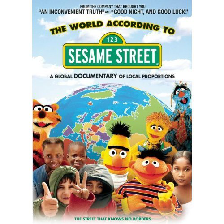

In [204]:
array_to_img(hf_visual_224['test_images'][idx_sesame])

**Movie Text**

In [205]:
print(' '.join(idx_word[w] for w in X_test[idx_sesame]))

a documentary which examines the creation and co - production of the popular children ' s television program in three developing countries : bangladesh , kosovo and south africa .


**Ground Truth**

In [206]:
tuple(genres_names[np.nonzero(y_test[idx_sesame])].tolist())

('Documentary',)

**Visual Prediction**

In [207]:
predict_interpret_unimodal(hf_visual_224['test_images'][idx_sesame], model_visual)

['Comedy', 'Family', 'Animation']

**Textual Prediction**

In [169]:
predict_interpret_unimodal(X_test2[idx_sesame], nlp_model)

['Documentary']

**Multimodal MaxAvePool Prediction**

In [208]:
predict_interpret_mmodal(hf_text['test_text'][idx_sesame], hf_visual['test_images'][idx_sesame])

['Documentary']

### Movie 2: 'Barbar The Movie'

**Movie Image**

In [190]:
idx_babar = 728

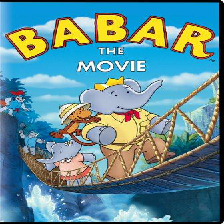

In [191]:
array_to_img(hf_visual_224['test_images'][idx_babar])

Movie Text

In [170]:
print(' '.join(idx_word[w] for w in X_test[idx_babar]))

in his spectacular film debut , young babar , king of the elephants , must save his homeland from certain destruction by rataxes and his band of invading rhinos .


Ground Truth

In [171]:
tuple(genres_names[np.nonzero(y_test[idx_babar])].tolist())

('Adventure', 'Fantasy', 'Family', 'Animation', 'Musical')

**Visual Prediction**

In [189]:
predict_interpret_unimodal(hf_visual_224['test_images'][idx_babar], model_visual)

['Comedy']

**Textual Prediction**

In [174]:
predict_interpret_unimodal(X_test2[idx_babar], nlp_model)

['Comedy']

**Multimodal MaxAvePool Prediction**

In [192]:
predict_interpret_mmodal(hf_text['test_text'][idx_babar], hf_visual['test_images'][idx_babar])

[]

### Movie 3: 'Letters from two Iwo Jima'

**Movie Image**

In [193]:
idx_letter = 1553

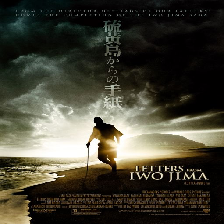

In [194]:
array_to_img(hf_visual_224['test_images'][idx_letter])

**Movie Text**

In [201]:
print(' '.join(idx_word[w] for w in X_test[idx_letter]))

the island of iwo jima stands between the american military force and the home islands of japan . therefore the imperial japanese army is desperate to prevent it from falling into american hands and providing a launching point for an invasion of japan . general tadamichi kuribayashi is given command of the forces on the island and sets out to prepare for the imminent attack . general kuribayashi , however , does not favor the rigid traditional approach recommended by his subordinates , and resentment and resistance fester among his staff . in the lower echelons , a young soldier , saigo , a poor baker in civilian life , strives with his friends to survive the harsh regime of the japanese army itself , all the while knowing that a fierce battle looms . when the american invasion begins , both kuribayashi and saigo find strength , honor , courage , and horrors beyond imagination .


Ground Truth

In [202]:
tuple(genres_names[np.nonzero(y_test[idx_letter])].tolist())

('Drama', 'War', 'History')

**Visual Prediction**

In [195]:
predict_interpret_unimodal(hf_visual_224['test_images'][idx_letter], model_visual)

['Drama']

**Textual Prediction**

In [177]:
predict_interpret_unimodal(X_test2[idx_letter], nlp_model)

['Drama', 'Action', 'War']

**Multimodal MaxAvePool Prediction**

In [196]:
predict_interpret_mmodal(hf_text['test_text'][idx_letter], hf_visual['test_images'][idx_letter])

['Drama', 'War']

### Movie 4: 'The Last Elvis'

**Movie Image**

In [197]:
idx_elvis = 6995

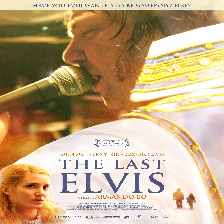

In [198]:
array_to_img(hf_visual_224['test_images'][idx_elvis])

**Movie Text**

In [178]:
print(' '.join(idx_word[w] for w in X_test[idx_elvis]))

a tragic accident causes an elvis impersonator to reassess his priorities .


**Ground Truth**

In [179]:
tuple(genres_names[np.nonzero(y_test[idx_elvis])].tolist())

('Drama',)

**Visual Prediction**

In [199]:
predict_interpret_unimodal(hf_visual_224['test_images'][idx_elvis], model_visual)

['Drama']

**Textual Prediction**

In [180]:
predict_interpret_unimodal(X_test2[idx_elvis], nlp_model)

['Comedy']

**Multimodal MaxAvePool Prediction**

In [200]:
predict_interpret_mmodal(hf_text['test_text'][idx_elvis], hf_visual['test_images'][idx_elvis])

['Drama', 'Comedy']

### Discuss examples

The predictions on movie 'The World according to Sesame Street' are according to the expectations, since the visual predicts genres like 'Animation' which fits with the image, the textual and multimodal predict 'Documentary' because the text is more expresive of the genre. We obtained bad results in 'Barbar The Movie' no model predicted the actual genres. The movie 'Leters for two Iowa Jima' has descent predictions on the three modalities, but the multimodal has a better prediction. The movie 'The last Elvis' has a good prediction with the visual model but a bad prediction with the textual model because the text is not very informative.
